*See README.md for a brief definition of the project.*

*This serie is composed by three notebooks:*
 - *exploratory_analysis.ipynb;*
 - *pre_processing.ipynb (this one); and*
 - *outlier_classification.ipynb.*

 


# **Preprocessing**

In this notebook, we will define the preprocessing actions that should run over the 
structured dataset before training. 


**Importing basic libraries**

In [1]:
import os

import datetime
import os.path
import re
import sys
import time
import yaml
import traceback
import numpy as np 
from collections import defaultdict
from datetime import datetime
import glob
import matplotlib.pyplot as plt

import multiprocessing as mp

import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import pandas as pd

import joblib

## Auxiliary Classes

### Logging

In [2]:

from datetime import datetime

class log:

    def __print(msg="", label=None, date=True, newline=True, ret=False):

        msg_aux = "" 
        
        if date:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"<{str_time}> "
            
        if label is not None:
            str_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            msg_aux = msg_aux + f"[ {label} ] "
            
        msg_aux = msg_aux + f"{msg}"
        
        if newline:
            msg_aux = msg_aux + f"\n"

        print(f"{msg_aux}")
        
        if ret:
            return ret
        
    def line(newline=False, ret=False):
        log.__print(msg="---------------------------------------------------", date=False, newline=False)

    def printMessage(msg, newline=False):
        log.line()
        log.__print(msg=msg, newline=False)
        log.line()
        if newline:
            print("")
        
    def info(msg, ret=False):
        log.__print(label="INFO", msg=msg, ret=ret)
        
    def err(msg,ret=False):
        log.__print(label="ERROR", msg=msg,ret=ret)
        
    def warn(msg,ret=False):
        log.__print(label="WARN", msg=msg,ret=ret)
        
    def ok(ret=False):
        log.__print(label="OK", msg="",ret=ret)

### Utilities


In [3]:
class utl:
    
    def __make_pretty(styler):
        styler.set_caption("Statistics")
        #styler.format(rain_condition)
        #styler.format_index(lambda v: v.strftime("%A"))
        #styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="YlGnBu")
        styler.background_gradient(axis=None, vmin=0, vmax=10000, cmap="gray")
        return styler
    
    def view_statistics(describe):
        return describe.T.loc[:].style.pipe(utl.__make_pretty)
        







### Directory structure 

In [4]:

class Directories:
    
    SEP="/"
    
    def __init__(self, pandas_dirname=None, checkpoint_dirname=None, ambar_path=None, csv_dirname=None, dumps_dirname=None, models_dirname=None, verbose=False):
        self.pandas_dirname = pandas_dirname
        self.checkpoint_dirname = checkpoint_dirname
        self.ambar_path = ambar_path
        self.csv_dirname = csv_dirname
        self.dumps_dirname = dumps_dirname
        self.models_dirname = models_dirname
        self.verbose = verbose
        
    def __str__(self):
        ret = "[ INFO ] Main directories:\n" + str(self.__dict__)
        return ret

In [5]:

dirs = Directories( 
    ambar_path=None, 
    csv_dirname=None,
    dumps_dirname=None,
    pandas_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/pandas2/rtm/balancin/",
    checkpoint_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/",
    models_dirname="/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/",
    )
log.info(str(dirs))
#rtm3d_azambuja_2023_07.pkl

<2023-07-07 12:26:30> [ INFO ] [ INFO ] Main directories:
{'pandas_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/datasets/pandas2/rtm/balancin/', 'checkpoint_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/', 'ambar_path': None, 'csv_dirname': None, 'dumps_dirname': None, 'models_dirname': '/atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/', 'verbose': False}



### Structured Data Reader

In [6]:

class StructuredDataReader:
    
    def __init__(self, dirs : Directories = None, verbose=False):
        self.dirs=dirs
        self.verbose=verbose

    def read(self):
        start_time = time.time()
        search_str = self.dirs.pandas_dirname + "**/*.pkl"
        filelist = [f for f in glob.glob(search_str, recursive=True)]
        
        dfs_list = list() 
        for f in filelist:
            if self.verbose:
                log.info(f"Reading [{f}]!")
            dfs_list.append(pd.read_pickle(f))
            
        df = pd.concat(dfs_list)
        
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to build: {end_time - start_time}')
            
        return  df


## Understanding the Structured Dataset

In [7]:
X = StructuredDataReader(dirs).read()


In [8]:
X

,worktime,workerid,nodelist,average,median,std,file,origin,ChaveSecDisco,MEM,...,tipomig,tipomodelagem,tipoprop,tiporefletividade,versao,zmax,zmin,zsup,worktime_seconds,distance
0,0 days 00:32:49,9.0,gr09b04n02,1903.400000,1903.5,3.666061,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,0.0,30360.0,...,2.0,0.0,2.0,0.0,B3_0_9,12000.0,0.0,0.0,1969,-17.893867
1,0 days 00:31:46,9.0,gr09b04n02,1903.400000,1903.5,3.666061,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,0.0,30360.0,...,2.0,0.0,2.0,0.0,B3_0_9,12000.0,0.0,0.0,1906,-0.709208
2,0 days 00:31:45,9.0,gr09b04n02,1903.400000,1903.5,3.666061,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,0.0,30360.0,...,2.0,0.0,2.0,0.0,B3_0_9,12000.0,0.0,0.0,1905,-0.436436
3,0 days 00:31:49,9.0,gr09b04n02,1903.400000,1903.5,3.666061,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,0.0,30360.0,...,2.0,0.0,2.0,0.0,B3_0_9,12000.0,0.0,0.0,1909,-1.527525
4,0 days 00:31:44,9.0,gr09b04n02,1903.400000,1903.5,3.666061,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,/arcade/data/Dumps_Remotos/4054_Dump_RTM3D.000...,0.0,30360.0,...,2.0,0.0,2.0,0.0,B3_0_9,12000.0,0.0,0.0,1904,-0.163663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18681443,0 days 00:09:48,189.0,gr12b09n06,1005.653261,1005.0,36.954855,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,0.0,47084.0,...,2.0,0.0,2.0,0.0,R3_2_8,12000.0,0.0,0.0,588,11.301716
18681444,0 days 00:13:03,189.0,gr12b09n06,1005.653261,1005.0,36.954855,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,0.0,47084.0,...,2.0,0.0,2.0,0.0,R3_2_8,12000.0,0.0,0.0,783,6.025007
18681445,0 days 00:10:34,189.0,gr12b09n06,1005.653261,1005.0,36.954855,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,0.0,47084.0,...,2.0,0.0,2.0,0.0,R3_2_8,12000.0,0.0,0.0,634,10.056954
18681446,0 days 00:12:39,189.0,gr12b09n06,1005.653261,1005.0,36.954855,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,/arcade/data/Dumps_Remotos/9443280_Dump_RTM3D....,0.0,47084.0,...,2.0,0.0,2.0,0.0,R3_2_8,12000.0,0.0,0.0,759,6.674448


In [9]:
worktime_mean = X["worktime"].mean()
exec_time_mean_sec = X["average"].mean()
chavesec_disco = X["ChaveSecDisco"].mean()
log.info(f"worktime_mean = {worktime_mean}")
log.info(f"exec_time_mean_sec = {exec_time_mean_sec}")
log.info(f"chavesec_disco = {chavesec_disco}")


<2023-07-07 12:26:57> [ INFO ] worktime_mean = 0 days 00:16:26.993067614

<2023-07-07 12:26:57> [ INFO ] exec_time_mean_sec = 980.1728303446843

<2023-07-07 12:26:57> [ INFO ] chavesec_disco = 0.0



In [10]:
numeric_columns = list()
categorical_columns = list()
other_columns = list()
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        numeric_columns.append(c)
    elif pd.api.types.is_categorical_dtype(X[c]):
        categorical_columns.append(c)
    else:
        other_columns.append(c)
        
log.line()
log.info(f"Numerical attritutes (#{len(numeric_columns)}):")
print(numeric_columns)
log.line()
log.info(f"Other attritutes (#{len(other_columns)})")
print(other_columns)
log.line()
log.info(f"Categorical attritutes (#{len(categorical_columns)})")
print(categorical_columns)
log.line()



---------------------------------------------------
<2023-07-07 12:26:57> [ INFO ] Numerical attritutes (#109):

['workerid', 'average', 'median', 'std', 'ChaveSecDisco', 'MEM', 'PPG', 'abertx', 'aberty', 'angmax', 'angmin', 'camada_de_agua', 'comp_contrib', 'comp_estrategia', 'comp_limruido', 'comp_offsetmaxz', 'comp_perccortemaxfim', 'comp_perccortemaxini', 'comp_perccorteminfim', 'comp_perccorteminini', 'comp_posneg', 'delta_incsou', 'deltavmin', 'dt', 'dxsup', 'dysup', 'dz', 'fat_eps', 'fatorLi', 'freqmax', 'freqmin', 'gathermax', 'gathermin', 'iOndaPlana', 'imagem', 'interpx', 'interpy', 'ioperacao', 'iorg_dado', 'iprxe', 'iprxs', 'iprxv', 'iprye', 'iprys', 'ipryv', 'itipocfar', 'iulxe', 'iulxs', 'iulxv', 'iulye', 'iulys', 'iulyv', 'mabx', 'maby', 'maxntrac', 'namost', 'nang', 'nborda', 'nfftny', 'nfinline', 'ngather', 'ngrupos', 'nh', 'noffs', 'npad', 'nprocs', 'nvmmax', 'nxe', 'nxtMax', 'nye', 'nytMax', 'nz', 'offmax', 'offmin', 'offxmax', 'offymax', 'ppg', 'profMigIni', 'profh2

In [11]:
X_resume = X.describe()


In [12]:
utl.view_statistics(X_resume)

,count,mean,std,min,25%,50%,75%,max
worktime,18681448,0 days 00:16:26.993067614,0 days 02:50:59.899206917,0 days 00:00:01,0 days 00:04:44,0 days 00:11:32,0 days 00:19:14,82 days 03:56:07
workerid,18681448.000000,122.308950,141.511953,1.000000,29.000000,76.000000,161.000000,960.000000
average,18681448.000000,980.172830,1617.779211,1.000000,294.115000,738.176230,1243.111538,67182.000000
median,18681448.000000,968.199972,1501.117988,1.000000,294.000000,735.000000,1209.000000,67182.000000
std,18681448.000000,84.550310,554.100649,0.000000,2.323991,5.332864,14.871211,14561.173919
ChaveSecDisco,18681448.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MEM,18681448.000000,25280.587519,20011.871719,0.000000,7464.000000,23211.000000,45092.000000,77721.000000
PPG,18681448.000000,2.960204,63.076657,0.000000,2.000000,2.000000,4.000000,136266.000000
abertx,18681448.000000,11083.430319,1604.106462,0.000000,10000.000000,12000.000000,12000.000000,20000.000000
aberty,18681448.000000,10825.334426,2057.684586,0.000000,10000.000000,12000.000000,12000.000000,16000.000000


## Preprocessing Pipeline

This implementation uses the sklearn Pipeline framework for representing the sequence of transformation over the dataset.

### Data Copy

In [13]:

class Outplace(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("Making a copy from the original dataset...")
        X = X.copy()
        if v: log.printMessage("End")
        return X
    


### Cleaning

In [14]:


class Cleanner_DropEmptyAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, describe=None, verbose=False):
        self.resume = describe
        self.verbose = verbose
    
    def __describe(self, X):
        if self.resume is None:
            if self.verbose:
                log.info("Calling describe() on original dataframe (may take long)...")
            self.resume = X.describe()
            if self.verbose:
                log.ok()
        else:
            if self.verbose:
                log.info("describe() ok! Nothing to be done!")
        return self.resume    
    
    def __select_column(self, column):
        discard = False
        # only zeros
        if column["min"] == 0 and column["max"] == 0:
            discard = True
        # same values
        elif column["min"] == column["max"]:
            discard = True
        return not discard
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        if self.resume is None:
            self.__describe(X)
            
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: dropping empty attributes...")
        
        if v: log.info("Dropping attributes automatically...")
        cols2drop = list()
        for c in set(self.resume.columns): #iterate over numerical columns only
            if not self.__select_column(self.resume[c]):
                cols2drop.append(c)
        if len(cols2drop) > 1:
            if self.verbose:
                if v: log.warn(f"    {len(cols2drop)} attributes will be removed!")
            X.drop(columns=cols2drop, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    


In [15]:


class Cleanner_DropAttributesByExpert(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: dropping attributes by human decision (expert)...")
        
        if v: log.info("Dropping attributes by expert...")
        manual_drop_cols = ["workerid", "distance", "worktime", "median", "file", "origin", \
            "refl_incx", "refl_incy", "refl_iprx", "refl_ipry", "refl_iulx", \
            "refl_iuly", "refl_z0", "refl_zf", "refl_zinc", "restr_eventos", \
            "tempo_checkpoint", "iprxe", "iprxs", "iprxv", "iprye", "iprys", \
            "ipryv", "iulxe", "iulxs", "iulxv", "iulye", "iulys", "iulyv", "nprocs",
            "node",
            "MEM", "PPG", # MEM has unexpected values. besides, the information is constant for the same cluster. PPG is redundant with ppg
            ]
        X.drop(columns=manual_drop_cols, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    

#pesos = "ppg", "mabx", "maby"



In [16]:


class Cleanner_DropRowsWithGarbage(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("Cleanning")
        
        if v: log.info("Dropping rows with only zeros...")
        X = X.loc[~(X == 0).all(axis=1)]
        if v: log.ok()
        
        if v: log.info("Dropping rows with missing values in most column...")
        X.drop(index=X[X["MEM"] == 0].index, inplace=True)
        if v: log.ok()
        
        if v: log.info("Dropping rows with beta and dev versions...")
        X.drop(index=X[X["versao"] == "Beta"].index, inplace=True)
        X.drop(index=X[X["versao"] == "DEV"].index, inplace=True)
        if v: log.ok()
        
        if v: log.info("Reseting indexes...")
        X.reset_index(drop=True, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



In [17]:


class Cleanner_RenamingAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, describe=None, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Cleanning: renaming some attributes for better meaning...")
        
        if v: log.info("Renaming column name from 'average' to 'y_estimated'...")
        X.rename(columns={'std': 'y_std'}, inplace=True)
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'average' to 'y_estimated'...")
        X.rename(columns={'average': 'y_estimated'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X
    


### Transforming

In [18]:


class Transformer_DataTypeConversion(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Transformation: converting column data types...")
        
        if v: log.info("Renaming column name from 'average' to 'y_estimated'...")
        X.rename(columns={'worktime_seconds': 'time_exec_sec'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



In [19]:


class Transformer_BasicStringClustering(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        
        v = self.verbose    
        
        if v: log.printMessage("Transformation: clustering some categorical attributes...")
        
        if v: log.info("From node to machine name...")
        X['nodelist'] = X['nodelist'].str[:4]
        if v: log.ok()
        
        if v: log.info("From direm to file system name...")
        X['dirrem']  = X['dirrem'].str.partition('/')[2].str.partition('/')[0]
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'nodelist' to 'machine_name'...")
        X.rename(columns={'nodelist': 'machine_name'}, inplace=True)
        if v: log.ok()
        
        if v: log.info("Renaming column name from 'dirrem' to 'fs_name'...")
        X.rename(columns={'dirrem': 'fs_name'}, inplace=True)
        if v: log.ok()
        
        if v: log.printMessage("End")
        
        return X



### Filling Missing Values

In [20]:

class Filler(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        # No fitting is needed for cleaning, so we return self
        return self
    
    def transform(self, X):
        v = self.verbose    
        if v: log.printMessage("It is not necessary to worry about the missing values neither outliers.")
        return X
    


### Pipeline Wrappers


In [21]:


class CleannerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('cleanner 1', Cleanner_DropRowsWithGarbage(verbose=verbose)),
            ('cleanner 2', Cleanner_DropAttributesByExpert(verbose=verbose)), 
            ('cleanner 3', Cleanner_DropEmptyAttributes(verbose=verbose)),
            ('cleanner 4', Cleanner_RenamingAttributes(verbose=verbose)),
            ])


class FillerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('filler', Filler(verbose=verbose)),     # treat missing values
            ])


class TransformerPipe:
    def get_pipe(verbose=False):
        return Pipeline([
            ('string clustering', Transformer_BasicStringClustering(verbose=verbose)),
            ('data type conversion', Transformer_DataTypeConversion(verbose=verbose)),
            ])
        
    def get_pipe_with_onehot_encoding(features_to_encoding=None, other_features=None, verbose=False):
        
        assert features_to_encoding is not None, f"parameter features_to_encoding must be present"
        assert other_features is not None, f"parameter other_features must be present"
        
        return Pipeline([
            ('onehot', ColumnTransformer([
                ('onehot', OneHotEncoder(), features_to_encoding),
                ('numeric', 'passthrough', other_features),
                ])),
            ('scaler', MinMaxScaler(feature_range=(0, 1))),
            ])



class PreprocessingPipe:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.features_to_encoding = None
        self.other_features = None
        self.pipeline = None
        self.onehot_pipeline = None
    
    def __get_pipe(self):
        return Pipeline([
            ('outplace', Outplace(verbose=self.verbose)),               # make a copy of the original data
            ('cleanner', CleannerPipe.get_pipe(verbose=self.verbose)),  # clean data, remove outliers and rename columns
            ('filler', FillerPipe.get_pipe(verbose=self.verbose)),      # treat missing values
            ('transfomer', TransformerPipe.get_pipe(verbose=self.verbose)),     # treat missing values
            ])

    def __get_pipe_with_onehot_encoding(self):
        return Pipeline([
            ('outplace', Outplace(verbose=self.verbose)),               # make a copy of the original data
            ('transformer', TransformerPipe.get_pipe_with_onehot_encoding(features_to_encoding=self.features_to_encoding, other_features=self.other_features, verbose=self.verbose)),     # treat missing values
            ])
    
    def __get_other_features(self, X):
        other = list()
        for c in X.columns:
            if c not in self.features_to_encoding:
                other.append(c)
        return other

    def fit_transform(self, X):
        self.pipeline = self.__get_pipe()
        return self.pipeline.fit_transform(X)

    def onehot_fit_transform(self, X, features_to_encoding=None):
        self.features_to_encoding = features_to_encoding
        assert self.features_to_encoding is not None, f"parameter features_to_encoding must be present"
        
        self.other_features = self.__get_other_features(X)
        
        self.onehot_pipeline = self.__get_pipe_with_onehot_encoding()
        XX = self.onehot_pipeline.fit_transform(X)
        
        encoder = self.onehot_pipeline.named_steps['transformer'].named_steps['onehot'].named_transformers_['onehot']
        column_names = list(encoder.get_feature_names_out(self.features_to_encoding)) + self.other_features
        
        XX_df = pd.DataFrame(XX, columns=column_names)
        return XX_df



## Preprocessing

### Generating X2 (the dataset after preprocessing)

In [22]:
pipe = PreprocessingPipe(verbose=True)
X2 = pipe.fit_transform(X)


---------------------------------------------------
<2023-07-07 12:28:38> Making a copy from the original dataset...
---------------------------------------------------
---------------------------------------------------
<2023-07-07 12:29:00> End
---------------------------------------------------
---------------------------------------------------
<2023-07-07 12:29:00> Cleanning
---------------------------------------------------
<2023-07-07 12:29:00> [ INFO ] Dropping rows with only zeros...

<2023-07-07 12:29:21> [ OK ] 

<2023-07-07 12:29:21> [ INFO ] Dropping rows with missing values in most column...

<2023-07-07 12:29:34> [ OK ] 

<2023-07-07 12:29:34> [ INFO ] Dropping rows with beta and dev versions...

<2023-07-07 12:29:55> [ OK ] 

<2023-07-07 12:29:55> [ INFO ] Reseting indexes...

<2023-07-07 12:29:55> [ OK ] 

---------------------------------------------------
<2023-07-07 12:29:55> End
---------------------------------------------------
----------------------------------

### Understanding X2

#### Basic statistics

In [23]:
#X2["fs_name"].hist()
#X2["machine_name"].hist()
#X2["MEM"].astype("category").hist()
#plt.show()
X2_resume = X2.describe()

In [24]:
log.info(f"X  (#attributes, #columns) = ({len(X)}, {len(X.columns)}) ")
log.info(f"X2 (#attributes, #columns) = ({len(X2)}, {len(X2.columns)}) ")
utl.view_statistics(X2_resume)

<2023-07-07 12:31:54> [ INFO ] X  (#attributes, #columns) = (18681448, 116) 

<2023-07-07 12:31:54> [ INFO ] X2 (#attributes, #columns) = (14737882, 48) 



,count,mean,std,min,25%,50%,75%,max
y_estimated,14737882.000000,1001.251628,1464.859409,8.000000,271.736667,749.700000,1315.914634,42802.609375
y_std,14737882.000000,99.418438,613.208819,0.000000,1.708701,6.315930,14.657705,14561.173919
abertx,14737882.000000,11069.256882,1697.923966,2000.000000,10000.000000,12000.000000,12000.000000,20000.000000
aberty,14737882.000000,10805.456494,2132.783759,2000.000000,10000.000000,12000.000000,12000.000000,16000.000000
angmax,14737882.000000,0.123221,3.327871,0.000000,0.000000,0.000000,0.000000,90.000000
comp_contrib,14737882.000000,0.731218,0.443326,0.000000,0.000000,1.000000,1.000000,1.000000
dt,14737882.000000,0.005553,0.003317,0.003000,0.004000,0.004000,0.004000,0.016000
dxsup,14737882.000000,16.373819,7.365371,7.000000,12.500000,12.500000,20.000000,49.750000
dysup,14737882.000000,16.373819,7.365371,7.000000,12.500000,12.500000,20.000000,49.750000
dz,14737882.000000,16.373819,7.365371,7.000000,12.500000,12.500000,20.000000,49.750000


In [25]:
a = np.array(X2["y_estimated"])
std = np.array(X2["y_std"])
t = np.array(X2["time_exec_sec"])
f = t/a
o = np.full(len(f), False)
o[f < 0.8] = True
o[f > 1.2] = True
print(f"y_est = {a[:10]}")
print(f"time = {t[:10]}")
print(f"razao = {f[:10]}")
print("#outliers = ", len(o[o == True]))
print(len(o))

log.line()
distance = np.zeros(a.shape, dtype=np.float64)
for i in range(len(a)):
    if std[i] > 1:
        distance[i] = np.abs(t[i]-a[i])/std[i]
    else:
        distance[i] = 0 #np.abs(t[i]-a[i])



y_est = [1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4]
time = [1969 1906 1905 1909 1904 1903 1911 1906 1911 1899]
razao = [1.03446464 1.00136598 1.0008406  1.0029421  1.00031523 0.99978985
 1.00399285 1.00136598 1.00399285 0.99768835]
#outliers =  3800492
14737882
---------------------------------------------------


In [26]:
o = np.full(len(f), False)
o[distance > 4] = True
print(f"y_est = {a[:10]}")
print(f"time = {t[:10]}")
print(f"razao = {f[:10]}")
print(f"std = {std[:10]}")
print(f"distance = {distance[:10]}")
print(len(o))
print("#outliers = ", len(o[o == True]))



y_est = [1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4 1903.4]
time = [1969 1906 1905 1909 1904 1903 1911 1906 1911 1899]
razao = [1.03446464 1.00136598 1.0008406  1.0029421  1.00031523 0.99978985
 1.00399285 1.00136598 1.00399285 0.99768835]
std = [3.66606056 3.66606056 3.66606056 3.66606056 3.66606056 3.66606056
 3.66606056 3.66606056 3.66606056 3.66606056]
distance = [17.893867    0.70920814  0.43643578  1.52752523  0.16366342  0.10910895
  2.07306996  0.70920814  2.07306996  1.2001984 ]
14737882
#outliers =  7164719


#### Numerical Attributes


##### Box plot

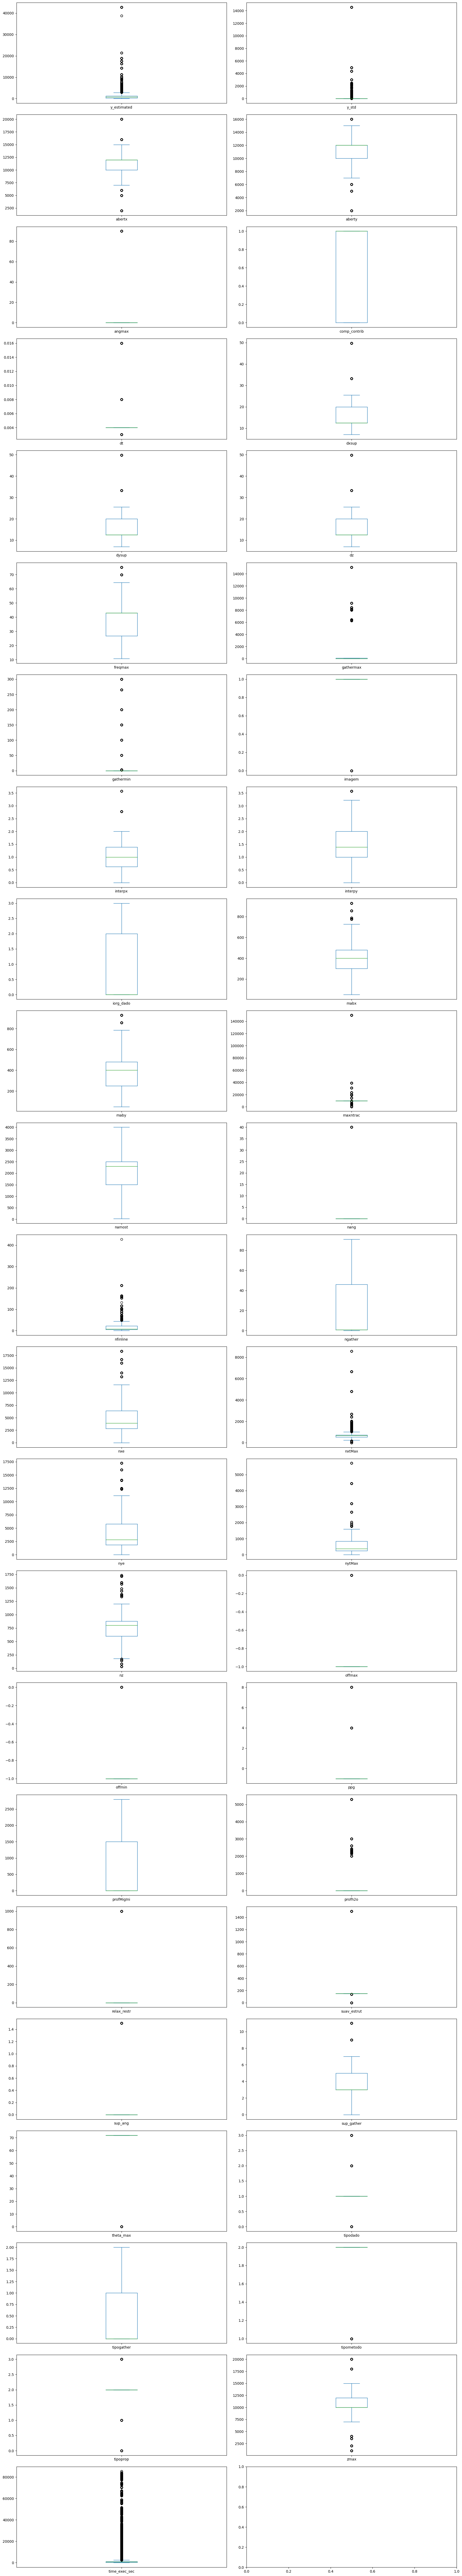

In [27]:

numeric_columns = list()
for i, c in enumerate(X2.columns[:]):
    if pd.api.types.is_numeric_dtype(X2[c].dtype):
        numeric_columns.append(c)

ncols = 2
nrows = len(numeric_columns)//ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 100))  

axs = axs.flatten()

# Iterate over each column and plot the histogram
for i, c in enumerate(numeric_columns):
    X2.plot(y=[c], kind="box", ax=axs[i])  # Adjust the number of bins as needed
    #axs[i].set_xlabel(c)
    #axs[i].set_ylabel('Frequency')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=2)  # Adjust the value as per your needs
plt.tight_layout()

# Display the plot
plt.show()


##### Histograms


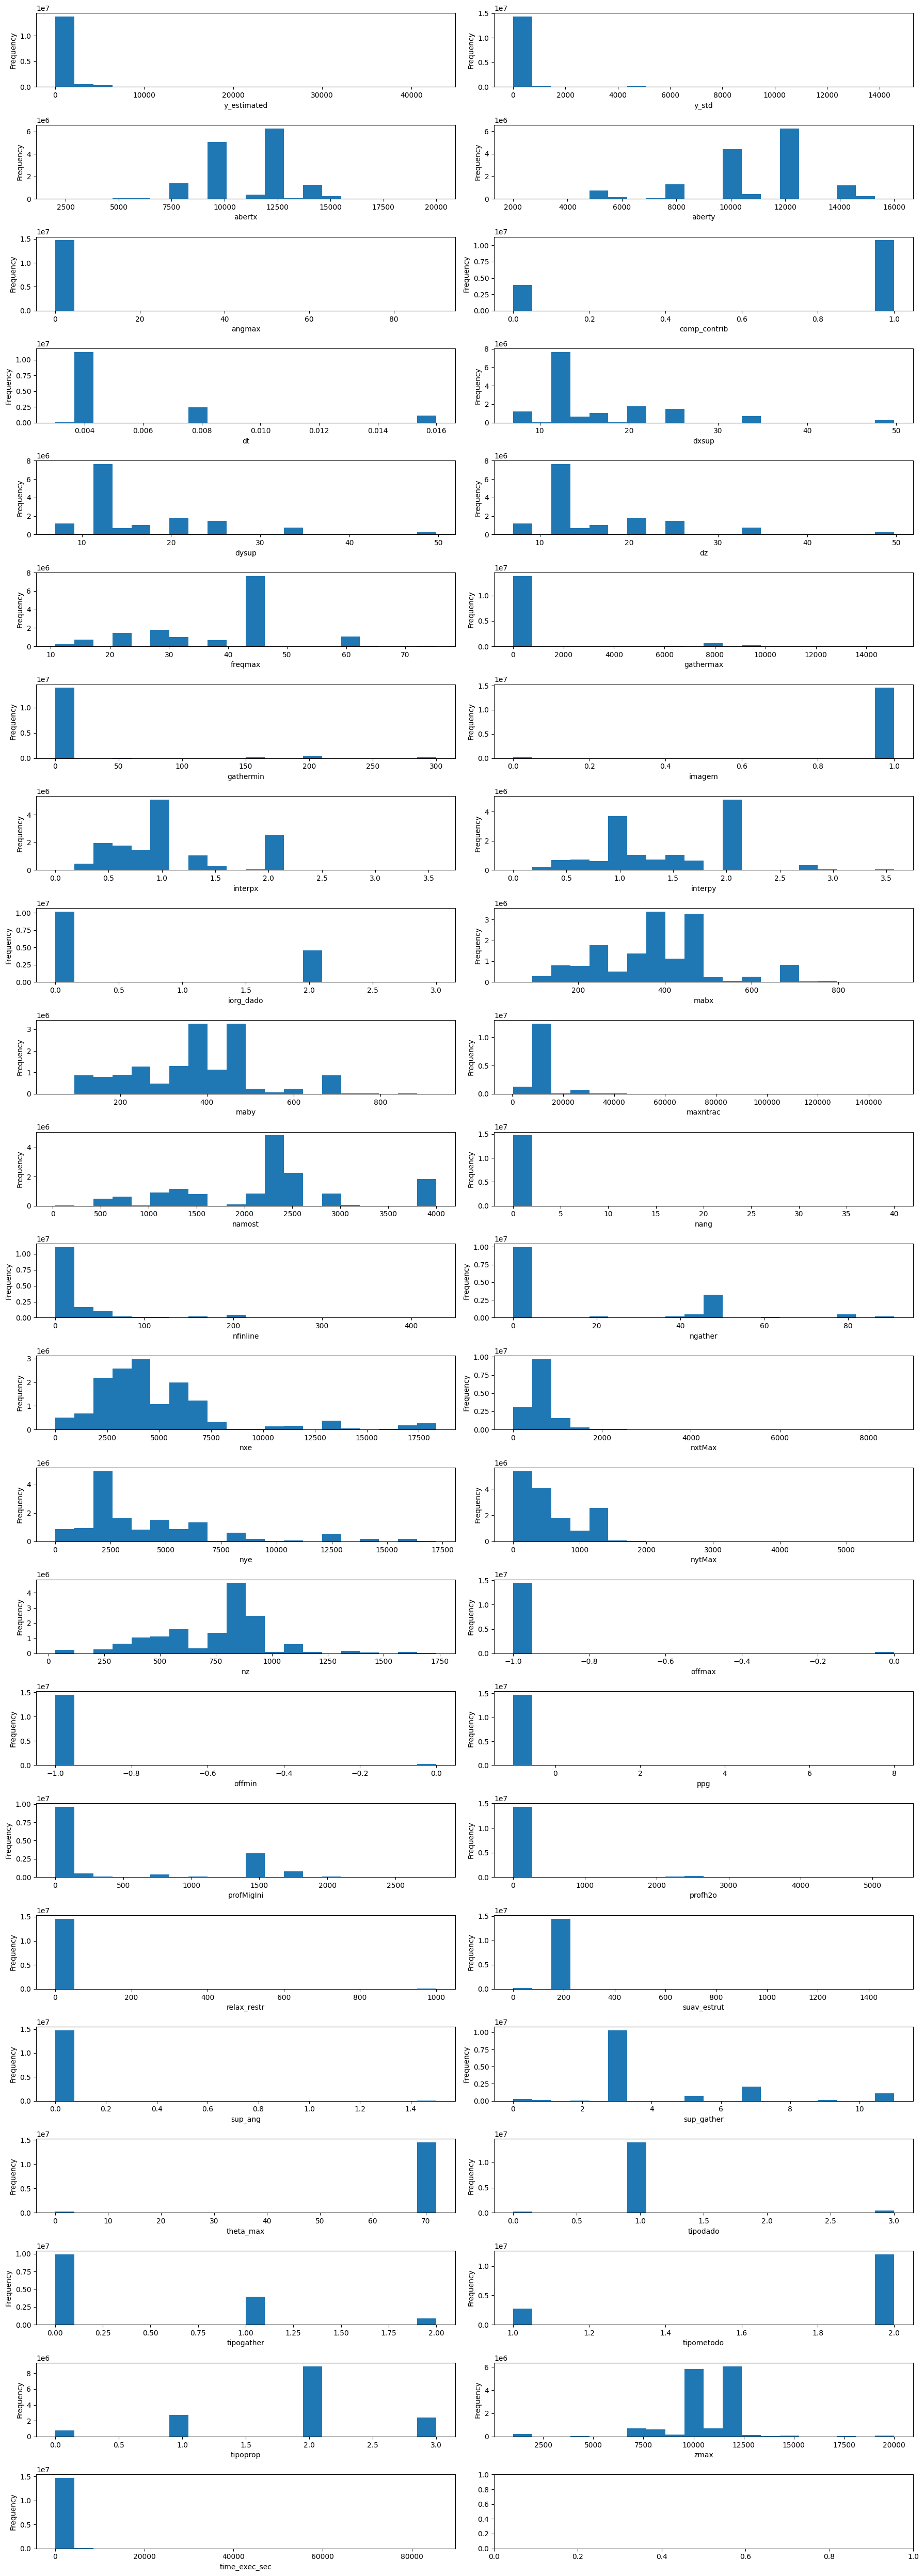

In [28]:

numeric_columns = list()
for i, c in enumerate(X2.columns[:]):
    if pd.api.types.is_numeric_dtype(X2[c].dtype):
        numeric_columns.append(c)

ncols = 2
nrows = len(numeric_columns)//ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 50))  

axs = axs.flatten()

# Iterate over each column and plot the histogram
for i, c in enumerate(numeric_columns):
    data = pd.to_numeric(X2[c], errors='coerce')  # Convert column data to numeric type
    data = data.dropna()  # Remove any NaN values if present
    axs[i].hist(data, bins=20)  # Adjust the number of bins as needed
    axs[i].set_xlabel(c)
    axs[i].set_ylabel('Frequency')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=2)  # Adjust the value as per your needs
plt.tight_layout()

# Display the plot
plt.show()


#### Nominal Attributes


##### Histograms

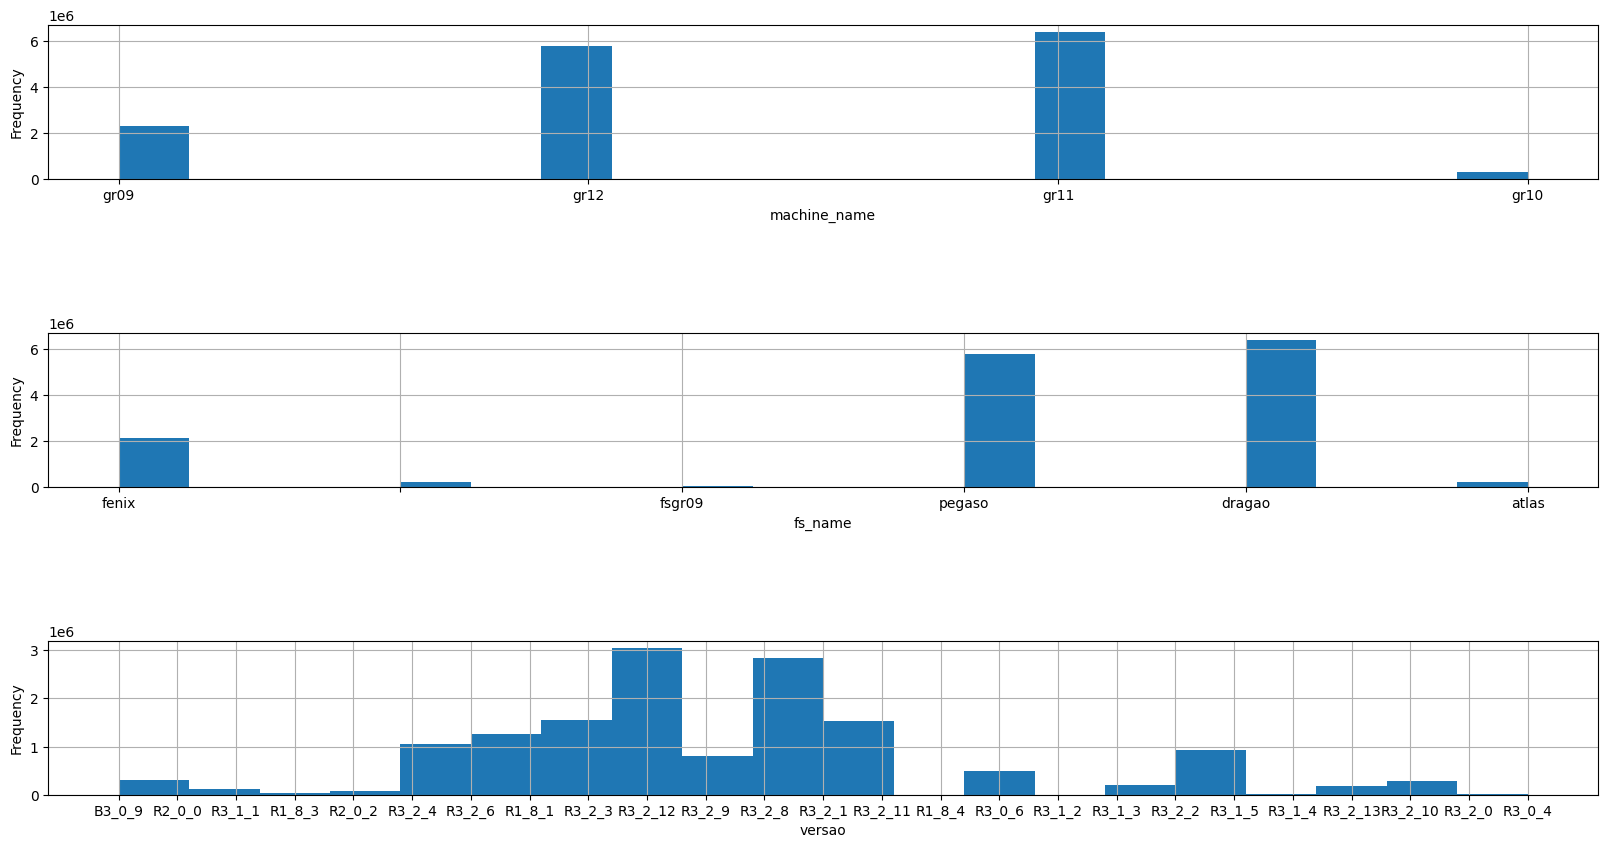

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

non_numeric_columns = list()
for i, c in enumerate(X2.columns[:]):
    if not pd.api.types.is_numeric_dtype(X2[c].dtype):
        non_numeric_columns.append(c)
        
# Calculate the number of rows and columns for the subplots
ncols = 1
nrows = len(non_numeric_columns)//ncols

# Create a figure and subplots with the specified number of rows and columns
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))  # Adjust figsize as per your needs

# Flatten the 2D axs array for easier iteration
axs = axs.flatten()

# Iterate over each numerical column and plot the histogram using pandas hist method

for i, c in enumerate(non_numeric_columns):
    #print(f"column = {column} -- dtype = {X2[column].dtype}")
    X2[c].hist(ax=axs[i], bins=20)  # Adjust the number of bins as needed
    #axs[i].set_title(c)
    axs[i].set_xlabel(c)
    axs[i].set_ylabel('Frequency')

# Adjust the layout of subplots
#plt.tight_layout()
plt.subplots_adjust(hspace=1)  # Adjust the value as per your needs

# Display the plot
plt.show()


## More Preprocessing

### Extracting Labels

**IMPORTANT**:

This labels can't be trusted as true labels as in supervised problems. They are just the classification results of the statistical analysis performed by the current solution used in production (see README.md). They will help to compare our model against it.

In [30]:
y_labels = ['y_estimated', 'y_std']
Y = pd.DataFrame(X2[y_labels])  # this y isn't the label. It's the average time of the tasks processdes by the same job.
                                     # if the execution_time_secs differs too much from y, it may be caused the element is an outlier.
                                     # but it isn't necessarylly true. So, use Y as a poor estimation of the expected execution time.
X3 = X2.drop(y_labels, axis=1)

### One-hot Encoding and MinMaxNormalization


In [31]:

features_to_encoding = ["machine_name", "fs_name", "versao"]
X3 = pipe.onehot_fit_transform(X3, features_to_encoding=features_to_encoding)
assert len(X3) == len(Y), f"Y and X3 must have the same size and element ordering."

---------------------------------------------------
<2023-07-07 12:38:36> Making a copy from the original dataset...
---------------------------------------------------
---------------------------------------------------
<2023-07-07 12:38:39> End
---------------------------------------------------


In [32]:
X3_resume = X3.describe()

In [33]:
log.info(f"X2  (#attributes, #columns) = ({len(X2)}, {len(X2.columns)}) ")
log.info(f"X3 (#attributes, #columns) = ({len(X3)}, {len(X3.columns)}) ")

<2023-07-07 12:40:15> [ INFO ] X2  (#attributes, #columns) = (14737882, 48) 

<2023-07-07 12:40:15> [ INFO ] X3 (#attributes, #columns) = (14737882, 78) 



In [34]:
utl.view_statistics(X3_resume)

,count,mean,std,min,25%,50%,75%,max
machine_name_gr09,14737882.000000,0.154870,0.361780,0.000000,0.000000,0.000000,0.000000,1.000000
machine_name_gr10,14737882.000000,0.019650,0.138795,0.000000,0.000000,0.000000,0.000000,1.000000
machine_name_gr11,14737882.000000,0.433682,0.495582,0.000000,0.000000,0.000000,1.000000,1.000000
machine_name_gr12,14737882.000000,0.391798,0.488152,0.000000,0.000000,0.000000,1.000000,1.000000
fs_name_,14737882.000000,0.013624,0.115925,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_atlas,14737882.000000,0.014817,0.120819,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_dragao,14737882.000000,0.433679,0.495582,0.000000,0.000000,0.000000,1.000000,1.000000
fs_name_fenix,14737882.000000,0.143287,0.350365,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_fsgr09,14737882.000000,0.002796,0.052801,0.000000,0.000000,0.000000,0.000000,1.000000
fs_name_pegaso,14737882.000000,0.391798,0.488152,0.000000,0.000000,0.000000,1.000000,1.000000


In [35]:

Y_resume = Y.describe()

In [36]:
utl.view_statistics(Y_resume)

,count,mean,std,min,25%,50%,75%,max
y_estimated,14737882.000000,1001.251628,1464.859409,8.000000,271.736667,749.700000,1315.914634,42802.609375
y_std,14737882.000000,99.418438,613.208819,0.000000,1.708701,6.315930,14.657705,14561.173919


## Serialization

### Pipeline Serialization

In [37]:
class PipelineSerializationBase:
    PIPE_NAME = "pipeline_preprocess.pkl"
    ONEHOT_PIPE_NAME = "pipeline_onehot_preprocess.pkl"
    
    def __init__(self, pipe:PreprocessingPipe=None, models_dir=None, verbose=False):
        self.models_dir = models_dir
        self.verbose = verbose
        self.pipe = pipe

    def get_pipe_filename(self):
        return  self.models_dir + PipelineSerializationBase.PIPE_NAME
        
    def get_onehot_pipe_filename(self):
        return  self.models_dir + PipelineSerializationBase.ONEHOT_PIPE_NAME


class PipelineReader(PipelineSerializationBase):
    def __init__(self, pipe:PreprocessingPipe = None, models_dir=None, verbose=False):
        super().__init__(pipe=pipe, models_dir=models_dir, verbose=verbose)

    def __load(self, filename):
        if self.verbose:
            log.info(f"Loading pipeline from <{filename}>") 
        return joblib.load(filename)
        
    def load_pipe(self):
        filename = self.get_pipe_filename()
        return self.__load(filename)
    
    def load_onehot_pipe(self):
        filename = self.get_onehot_pipe_filename()
        return self.__load(filename)


class PipelineWriter(PipelineSerializationBase):
    def __init__(self, pipe:PreprocessingPipe = None, models_dir=None, verbose=False):
        super().__init__(pipe=pipe, models_dir=models_dir, verbose=verbose)

    def __dump(self, pipeline, filename):
        if self.verbose:
            log.info(f"Dumping pipeline to <{filename}>") 
        joblib.dump(pipeline, filename)
    
    def dump_pipe(self):
        filename = self.get_pipe_filename()
        self.__dump(self.pipe.pipeline, filename)
        
    def dump_onehot_pipe(self):
        filename = self.get_onehot_pipe_filename()
        self.__dump(self.pipe.onehot_pipeline, filename)



In [38]:
pipe_writer = PipelineWriter(pipe=pipe, models_dir=dirs.models_dirname,verbose=True)
pipe_writer.dump_pipe()
pipe_writer.dump_onehot_pipe()

<2023-07-07 12:40:17> [ INFO ] Dumping pipeline to </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/pipeline_preprocess.pkl>

<2023-07-07 12:40:17> [ INFO ] Dumping pipeline to </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/models/v0/rtm/pipeline_onehot_preprocess.pkl>



### Structured Preprocessed Data Serialization

In [39]:


class SerializationBase:
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        self.data = data
        self.checkpoint_dir = checkpoint_dir
        self.verbose = verbose



In [40]:


class PreprocessedDataSerializationBase(SerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        self.x_name = "X_preprocessed.pkl"

    def get_data_filename(self):
        return  self.checkpoint_dir + self.x_name


class PreprocessedDataReader(PreprocessedDataSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)

    def load(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Loading preprocessed data from <{filename}>") 
        self.data = joblib.load(filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to load: {end_time - start_time}')
        return self.data


class PreprocessedDataWriter(PreprocessedDataSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        
    def dump(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Dumping preprocessed data to <{filename}>") 
        joblib.dump(self.data, filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to dump: {end_time - start_time}')
    



In [41]:

class LabelSerializationBase(SerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        self.label_name = "Y_original.pkl"

    def get_data_filename(self):
        return  self.checkpoint_dir + self.label_name


class LabelReader(LabelSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)

    def load(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Loading preprocessed data from <{filename}>") 
        self.data = joblib.load(filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to load: {end_time - start_time}')
        return self.data


class LabelWriter(LabelSerializationBase):
    def __init__(self, data=None, checkpoint_dir=None, verbose=False):
        super().__init__(data=data, checkpoint_dir=checkpoint_dir, verbose=verbose)
        
    def dump(self):
        start_time = time.time()
        filename = self.get_data_filename()
        if self.verbose:
            log.info(f"Dumping preprocessed data to <{filename}>") 
        joblib.dump(self.data, filename)
        end_time = time.time()
        if self.verbose:
            log.info(f'Time to dump: {end_time - start_time}')
    



In [42]:
x_writer = PreprocessedDataWriter(data=X3, checkpoint_dir=dirs.checkpoint_dirname, verbose=True)
x_writer.dump()

<2023-07-07 12:40:18> [ INFO ] Dumping preprocessed data to </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/X_preprocessed.pkl>

<2023-07-07 12:40:33> [ INFO ] Time to dump: 15.459384441375732



In [43]:
y_writer = LabelWriter(data=Y, checkpoint_dir=dirs.checkpoint_dirname, verbose=True)
y_writer.dump()

<2023-07-07 12:40:33> [ INFO ] Dumping preprocessed data to </atlas/ntbs/doutorado/2semestre.2023.1/ele2345-data.mining/trabalho.final/checkpoints/Y_original.pkl>

<2023-07-07 12:40:35> [ INFO ] Time to dump: 1.3314929008483887



### Getting MinMaxScaler Parameters
This values will be needed later in order to unnormalize the data after inference.

In [49]:
# getting fitted min max values of the scaler 
# just for the time_exec_sec attribute
scaler = pipe.onehot_pipeline.named_steps["transformer"].named_steps["scaler"]
print(scaler)
print (scaler.data_min_.tolist()[-1])
print (scaler.data_max_.tolist()[-1])

MinMaxScaler()
1.0
85451.0
